# Implementing our novel approach with Naive Bayes

> Preprocessing: Clean and preprocess your dataset. This may include handling missing values, encoding categorical variables, and scaling features.

## Load dataset

In [65]:
from libs import data
from libs import kde_lib
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from libs.exp_lib import Density_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import norm
from sklearn.datasets import make_circles, make_moons, make_classification
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.datasets import load_iris,load_breast_cancer


def generate_outliers(X,y,outlier_proportion=.1):

    # Calculate the number of outliers to add
    num_outliers = int(outlier_proportion * len(X))
    # Generate random outlier points within the range of the dataset
    outliers_X = np.random.rand(num_outliers, 2) * (np.max(X, axis=0) - np.min(X, axis=0)) + np.min(X, axis=0)
    outliers_y = np.array([1] * num_outliers)  # Assign a class label to outliers

    # Concatenate outliers with the original dataset
    X = np.vstack((X, outliers_X))
    y = np.concatenate((y, outliers_y))
    return X, y

X0, y0 = data.load_data_outlier("banana") # OK

# =======================================================
#   Generate synthetic data with outliers
# =======================================================
#X0, y0 = make_moons(500, noise=.2, random_state=42)
#X0, y0 = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0,random_state=1, n_clusters_per_class=1) 
#X0, y0 = generate_outliers(X0, y0)
""" data = load_breast_cancer()
X0, y0 = data.data, data.target
selected_features = [0, 3] 
X0 = X0[:,selected_features] """
"""  # Introduce outliers by modifying some data points
outlier_proportion = .2
num_outliers = int(outlier_proportion * len(X0))
outliers_indices = np.random.choice(len(X0), num_outliers, replace=False)
outliers = np.random.uniform(low=-10, high=10, size=(num_outliers, 2))
X0[outliers_indices] = outliers
# Set labels for the outliers
y0[outliers_indices] = 1  """
# =======================================================
#   Done Generate  the synthetic data
# =======================================================

X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size=0.3, random_state=42)

## Preprocess the data

In [66]:
#data.feature_names

In [67]:
""" # Get the dimension of our data
dim = X_train.ndim

# Calculate the number of classes and features
classes = np.unique(y_train)
n_features = X_train.shape[1]

# Initialize robust densities
robust_densities = np.zeros((len(X_train), dim))

print(robust_densities.shape)
kernel = 'gaussian'
#h = .5 """


" # Get the dimension of our data\ndim = X_train.ndim\n\n# Calculate the number of classes and features\nclasses = np.unique(y_train)\nn_features = X_train.shape[1]\n\n# Initialize robust densities\nrobust_densities = np.zeros((len(X_train), dim))\n\nprint(robust_densities.shape)\nkernel = 'gaussian'\n#h = .5 "

## Step2 - step3 : Robust Kernel Density Estimation (RKDE) & Bandwidth Selection using HHO:

- Implement the RKDE algorithm with IRLS and Robust M-estimation (Hampel function) for each class.
- Calculate robust densities for each class based on the RKDE algorithm.


In [68]:

""" for class_label in classes:
    # GET for each class
    class_indices = np.where(y_train==class_label)[0]
    class_X = X_train[class_indices]
    h = kde_lib.hho_bandwith_selection(class_X,class_X)
    #h = .5
    # Get for each feature
    rkde_feature =[]
    for d in range(dim):
        X = class_X[:,d] 
        X = X[:,np.newaxis]
        #print(X.shape)
        model = Density_model("rkde", "banana", 0,kernel,h)
        model.fit(X,X,grid=None)
        rkde = model.density
        
        robust_densities[class_indices,d] = rkde[:,0] """

    


' for class_label in classes:\n    # GET for each class\n    class_indices = np.where(y_train==class_label)[0]\n    class_X = X_train[class_indices]\n    h = kde_lib.hho_bandwith_selection(class_X,class_X)\n    #h = .5\n    # Get for each feature\n    rkde_feature =[]\n    for d in range(dim):\n        X = class_X[:,d] \n        X = X[:,np.newaxis]\n        #print(X.shape)\n        model = Density_model("rkde", "banana", 0,kernel,h)\n        model.fit(X,X,grid=None)\n        rkde = model.density\n        \n        robust_densities[class_indices,d] = rkde[:,0] '

## Step4: Incorporating RKDE into Naive Bayes:

> - Modify Naive Bayes classifier to use the RKDE densities instead of traditional Gaussian densities.
> - For prediction, calculate the likelihood using the robust densities obtained from RKDE.

In [69]:
class RobustNaiveBayes(BaseEstimator, ClassifierMixin):

    def __init__(self) -> None:
        self.class_priors = None
        self.classes = None
        #self.robust_densities = None
        self.kernel = 'gaussian'
        self.classifiers = {}  # Store GaussianNB classifiers for each class
        self.robust_densities = {}  # Store robust densities for each class
        #self.Gclassifier = None
    
    def fit(self, X, y):
        """
        Fit the robust Naive Bayes model with RKDE densities.

        Parameters:
        X (array-like): Training data features.
        y (array-like): Training data labels.
        """
        
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        # Calculate class priors
        self.class_priors = np.array([np.mean(y==c) for c in self.classes])
        #self.feature_priors = np.array([np.mean(X[:,feature]) for feature in range(n_features)])

        # Initialize robust densities
        #robust_densities = np.zeros((n_samples, n_features))
        #robust_densities = np.zeros(n_samples)
        """ self.Gclassifier = GaussianNB()
        self.Gclassifier.fit(X,y) """

        for class_label in self.classes :
            # GET for each class
            class_indices = np.where(y==class_label)[0]
            class_data = X[class_indices]

            self.classifiers[class_label] = GaussianNB()
            self.classifiers[class_label].fit(class_data,y[class_indices])
            #X_plot = np.linspace(np.min(class_data),np.max(class_data),len(class_data))
            #X_plot = X_plot[:,np.newaxis]
            ## what's good for banana dataset
            #bandwidth = .95
            bandwidth = kde_lib.hho_bandwith_selection(class_data,class_data)
            model = Density_model("rkde","",0,self.kernel,bandwidth)
            model.fit(class_data, class_data, grid=None)
            rkde = model.density 
            self.robust_densities[class_label] = rkde[:,0]
        
        """ # Get for each feature
        for feature in range(n_features):
            #self.robust_densities[feature] = np.zeros(len(X))
            feature_data = X[:,feature]
            feature_data = feature_data[:,np.newaxis]
            self.classifiers[feature] = GaussianNB()
            self.classifiers[feature].fit(feature_data,y)
            bandwidth = .955
            #X_plot = np.linspace(np.min(feature_data),np.max(feature_data),len(feature_data))
            #X_plot = X_plot[:,np.newaxis] 
            #bandwidth = kde_lib.hho_bandwith_selection(feature_data,feature_data)
            #print(feature_data.shape)
            #X_plot = X_plot[:,np.newaxis]
            #print(X_plot.shape)
            model = Density_model("rkde","",0,self.kernel,bandwidth)
            model.fit(feature_data, feature_data, grid=None)
            rkde = model.density
            #print(robust_densities[class_indices,feature])
            #robust_densities[class_indices,feature] = rkde[:,0]
            self.robust_densities[feature] = rkde[:,0] """
        #self.robust_densities = np.array(robust_densities)
        

        

    def predict(self, X):
        """
        Predict class labels and RKDE likelihoods for input data.

        Parameters:
        X (array-like): Input data features.

        Returns:
        y_pred (array-like): Predicted class labels.
        rkde_likelihoods (array-like): RKDE likelihoods for each class.
        """
        n_samples, n_features = X.shape
        n_classes = len(self.classes)
        predictions = []

        for sample in X:
            likelihoods = []

            for class_label in self.classes:
                classifier = self.classifiers[class_label]
                robust_density = self.robust_densities[class_label]
                # Calculate the likelihood using the robust density and GaussianNB classifier
                #likelihoods.append(np.prod(norm.pdf(sample, loc=robust_density.mean(), scale=robust_density.std())))
                log_likelihood = classifier.predict_joint_log_proba(sample.reshape(1, -1))
                #log_likelihood = self.Gclassifier.predict_joint_log_proba(sample.reshape(1, -1))
                likelihood = np.prod(np.exp(log_likelihood * robust_density.reshape(-1, 1))) 
                likelihoods.append(likelihood)

            """ # Calculate likelihood for each feature
            for feature in range(n_features):
                classifier = self.classifiers[feature]
                robust_density = self.robust_densities[feature]
                # Calculate the likelihood using the robust density and GaussianNB classifier
                log_likelihood = classifier.predict_joint_log_proba(sample[feature].reshape(1, -1))
                likelihood = np.prod(np.exp(log_likelihood * robust_density.reshape(-1, 1))) 
                likelihoods.append(likelihood) """
 
            # Normalize likelihoods using class priors
            normalized_likelihoods = likelihoods * self.class_priors
            
            predicted_class = np.argmax(normalized_likelihoods)
            predictions.append(self.classes[predicted_class])

        ## what's good for banana dataset
        """ for sample in X:

            likelihoods = []

            # Calculate likelihood for each class
            for class_label in self.classes:
                # GET for each class
                #class_indices = np.where(self.y_train == class_label)[0]
                #classifier = self.classifiers[class_label]
                density = self.robust_densities[class_label]
                #likelihoods.append(np.prod(norm.pdf(sample, loc=density.mean(), scale=density.std())))
                log_likelihood = self.classifiers[class_label].predict_joint_log_proba(sample.reshape(1, -1))
                likelihood = np.prod(np.exp(log_likelihood * density.reshape(-1, 1)))
                likelihoods.append(likelihood)

            # Normalize likelihoods using class priors
            normalized_likelihoods = likelihoods * self.class_priors

            # Predict the class with the highest normalized likelihood
            predicted_class = np.argmax(normalized_likelihoods)
            predictions.append(self.classes[predicted_class]) """
            #predictions.append(self.Gclassifier.predict(normalized_likelihoods.reshape(1, -1)))
        """ # Calculate likelihood for each feature
            for feature in range(n_features):
                # GET for each class
                #class_indices = np.where(self.y_train == class_label)[0]
                density = self.robust_densities[feature]
                likelihoods.append(np.prod(norm.pdf(sample[feature], loc=density.mean(), scale=density.std())))
            
            # Normalize likelihoods using class priors
            normalized_likelihoods = likelihoods * self.feature_priors

            # Predict the class with the highest normalized likelihood
            #predicted_class = np.argmax(normalized_likelihoods)
            predicted_class = self.classifiers[feature].predict(normalized_likelihoods.reshape(-1, 1))
            predictions.append(self.classes[predicted_class]) """
        
        return np.array(predictions)
                


In [70]:
# Create and fit the RobustNaiveBayes classifier
classifier = RobustNaiveBayes()
classifier.fit(X_train, y_train)

normal_NB = GaussianNB()
normal_NB.fit(X_train, y_train)

2023/09/05 11:40:08 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: Solving 2-objective optimization problem with weights: [1 1].
2023/09/05 11:40:10 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 1, Current best: 0.007054416774425365, Global best: 0.007054416774425365, Runtime: 0.73327 seconds
2023/09/05 11:40:10 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 2, Current best: 0.007054416774425365, Global best: 0.007054416774425365, Runtime: 0.58634 seconds
2023/09/05 11:40:11 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 3, Current best: 0.007054416774425365, Global best: 0.007054416774425365, Runtime: 0.45446 seconds
2023/09/05 11:40:11 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 4, Current best: 0.007054416774425365, Global best: 0.007054416774425365, Runtime: 0.56853 seconds
2023/09/05 11:40:12 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 5, Current best: 0.007054416774425365, Global 

Result hho_bandwith_selection: [1.]
Stop at 6 iterations
Stop at 100 iterations


2023/09/05 11:40:15 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 1, Current best: 0.0016967037331494818, Global best: 0.0016967037331494818, Runtime: 0.48598 seconds
2023/09/05 11:40:16 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 2, Current best: 0.0016967037331494818, Global best: 0.0016967037331494818, Runtime: 0.55485 seconds
2023/09/05 11:40:17 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 3, Current best: 0.0016967037331494818, Global best: 0.0016967037331494818, Runtime: 0.67800 seconds
2023/09/05 11:40:17 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 4, Current best: 0.0016967037331494818, Global best: 0.0016967037331494818, Runtime: 0.83072 seconds
2023/09/05 11:40:18 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 5, Current best: 0.0016967037331494818, Global best: 0.0016967037331494818, Runtime: 0.70810 seconds
2023/09/05 11:40:19 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO:

Result hho_bandwith_selection: [1.]
Stop at 7 iterations
Stop at 100 iterations


GaussianNB()

In [71]:
# Check the shape of our train data and the robust densities
#print(X_train.shape)
#print(classifier.robust_densities.shape)

In [72]:
# Make predictions on the test set
y_pred = classifier.predict(X_test)
print(np.unique(y_pred))

normal_NB_pred = normal_NB.predict(X_test)
print(np.unique(normal_NB_pred))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred) 
print("Accuracy 1:", accuracy)
print("precision 1:", precision)
print("recall 1:", recall)
print("f1 1:", f1)

print("\n")
accuracy = accuracy_score(y_test, normal_NB_pred)
precision = precision_score(y_test, normal_NB_pred)
recall = recall_score(y_test, normal_NB_pred)
f1 = f1_score(y_test, normal_NB_pred )
print("Accuracy 2:", accuracy)
print("precision 2:", precision)
print("recall 2:", recall)
print("f1 2:", f1)

# 0.368421052631578 0.9005847953216374

[0 1]
[0 1]
Accuracy 1: 0.9266666666666666
precision 1: 0.9207920792079208
recall 1: 0.96875
f1 1: 0.9441624365482234


Accuracy 2: 0.7866666666666666
precision 2: 0.9324324324324325
recall 2: 0.71875
f1 2: 0.8117647058823529


## Classifiers Comparaison 

In [85]:
# =======================================================
#   Generate synthetic data with outliers
# =======================================================
#X0, y0 = make_moons(500, noise=.2, random_state=42)
X0, y0 = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0,random_state=1, n_clusters_per_class=1) 

 # Introduce outliers by modifying some data points
outlier_proportion = .1
num_outliers = int(outlier_proportion * len(X0))
outliers_indices = np.random.choice(len(X0), num_outliers, replace=False)
outliers = np.random.uniform(low=np.min(X0, axis=0)-5, high=np.max(X0, axis=0)+5, size=(num_outliers, 2))
X0[outliers_indices] = outliers
# Set labels for the outliers
y0[outliers_indices] = 1 
#X0, y0 = generate_outliers(X0, y0)
""" data = load_breast_cancer()
X0, y0 = data.data, data.target
selected_features = [0, 3] 
X0 = X0[:,selected_features] """

""" rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)  """
#X, y = data.load_data("banana")
# =======================================================
#   Done Generate  the synthetic data
# =======================================================
linearly_separable = (X0, y0)
classifiers = {
    "Naive Bayes": GaussianNB(),
    "Robust Naive Bayes": RobustNaiveBayes(),
}


#iris = load_iris()

datasets = [
    #make_moons(3000, noise=0.3, random_state=0),
    #make_circles(500, noise=0.2, factor=0.5, random_state=0),
    linearly_separable
]
datasets_name = [
    #"make_moons",
   # "make_circles ",
    "make_classification",
]

figure = plt.figure(figsize=(27, 9))
i = 1

<Figure size 2700x900 with 0 Axes>

2023/09/06 12:15:49 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: Solving 2-objective optimization problem with weights: [1 1].
2023/09/06 12:15:49 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 1, Current best: 0.00832523411821601, Global best: 0.00832523411821601, Runtime: 0.46005 seconds
2023/09/06 12:15:50 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 2, Current best: 0.00832523411821601, Global best: 0.00832523411821601, Runtime: 0.40360 seconds
2023/09/06 12:15:50 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 3, Current best: 0.007207824708163513, Global best: 0.007207824708163513, Runtime: 0.52299 seconds
2023/09/06 12:15:51 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 4, Current best: 0.007207824708163513, Global best: 0.007207824708163513, Runtime: 0.57747 seconds
2023/09/06 12:15:51 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 5, Current best: 0.007207824708163513, Global best

Result hho_bandwith_selection: [1.]
Stop at 6 iterations
Stop at 100 iterations


2023/09/06 12:15:55 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 1, Current best: 0.0029345486256973884, Global best: 0.0029345486256973884, Runtime: 0.52613 seconds
2023/09/06 12:15:56 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 2, Current best: 0.0029345486256973884, Global best: 0.0029345486256973884, Runtime: 0.67220 seconds
2023/09/06 12:15:56 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 3, Current best: 0.0029345486256973884, Global best: 0.0029345486256973884, Runtime: 0.52580 seconds
2023/09/06 12:15:57 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 4, Current best: 0.0029345486256973884, Global best: 0.0029345486256973884, Runtime: 0.67628 seconds
2023/09/06 12:15:57 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 5, Current best: 0.0029345486256973884, Global best: 0.0029345486256973884, Runtime: 0.44740 seconds
2023/09/06 12:15:58 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO:

Result hho_bandwith_selection: [1.]
Stop at 7 iterations
Stop at 16 iterations


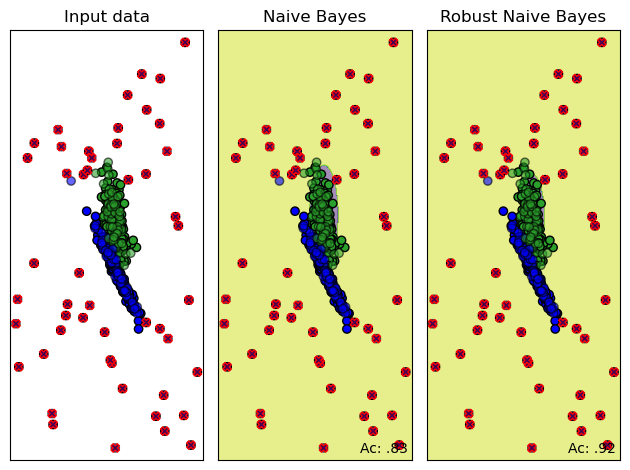

In [86]:
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#2ca02c", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) +1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k")
    # Plot the Outliers points
    ax.scatter(X[outliers_indices, 0], X[outliers_indices, 1],marker="X", c=y[outliers_indices], edgecolors="r")
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in classifiers.items():
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        # Create a meshgrid for plotting
        h = .02  # Step size in the mesh
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        #clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)

        # Make predictions using the classifier
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=.5)

        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        """ DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=.8, ax=ax, eps=.5
        ) """
        
        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )
        # Plot the Outliers points
        ax.scatter(X[outliers_indices, 0], X[outliers_indices, 1],marker="X", c=y[outliers_indices], edgecolors="r")
        
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("Ac: {}".format(("%.2f" % accuracy).lstrip("0"))),
            size=10,
            horizontalalignment="right",
        )
        i += 1
plt.tight_layout()
plt.show()